In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [30]:
# from urllib import request

# filenames = [
#     "train-images-idx3-ubyte.gz",
#     "train-labels-idx1-ubyte.gz",
#     "t10k-images-idx3-ubyte.gz",
#     "t10k-labels-idx1-ubyte.gz"
# ] # define file names

# # download from aws server to local
# folder = 'data/'
# base_url = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/"
# for name in filenames:
#     print("Downloading " + name + "...")

#     # lưu vào folder data_fashion_mnist
#     request.urlretrieve(base_url + name, folder + name) # retrieve base url downloading adress and folder name to download

In [31]:
import numpy as np
import gzip # download from zip file from google drive

with gzip.open('data/train-images-idx3-ubyte.gz', 'rb') as f:
    X_train = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28*28)

#? label not need to reshape bc it already 1D array
with gzip.open('data/train-labels-idx1-ubyte.gz', 'rb') as f:
    y_train = np.frombuffer(f.read(), np.uint8, offset=16)

with gzip.open('data/t10k-images-idx3-ubyte.gz', 'rb') as f:
    X_test = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28*28)

#? label not need to reshape bc it already 1D array
with gzip.open('data/t10k-labels-idx1-ubyte.gz', 'rb') as f:
    y_test = np.frombuffer(f.read(), np.uint8, offset=16)


In [32]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 784)
(59992,)
(10000, 784)
(9992,)


### Using Pytorch for cleaner download

In [ ]:
def get_mean_and_std(dataloader):
    channel_sum,

In [ ]:
from torchvision.datasets import FashionMNIST

data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


trainset = FashionMNIST(root='data', # define Root Folder that contain the datasets
                        train=True, # specify download training dataset only
                        download=True, transform=data_transforms # convert dtype to Tensor
                    )

testset =  FashionMNIST(root='test', # define Root Folder that contain the datasets
                        train=True, # specify download training dataset only
                        download=True, transform=data_transforms # convert dtype to Tensor
                    )

trainset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [90]:
img, label = trainset[0] # check if a sample contain img & label
print(type(img), label)

<class 'torch.Tensor'> 9


In [91]:
max_value = img.max()
print(max_value)
print(label)

tensor(1.)
9


In [95]:
import torch
from torch.utils.data import DataLoader, TensorDataset

count = 0
# Iterate through the dataloader to get one input at a time
for i in range(1):
    img, label = trainset[0] # check if a sample contain img & label
    # inputs will have a shape of [1, 3, 32, 32] (batch size 1)
    # targets will have a shape of [1]
    print(f"Shape of input batch: {img.shape}")
    count += 1
    # You can now pass 'inputs' to your model
    # model(inputs)

print(count)

Shape of input batch: torch.Size([1, 28, 28])
1


**Pytorch/Tensor Format (C, H, W)** - Channel Dimension, Height, Width

**Numpy/Matplotlib Format (H, W, C)** - Height, Width, Channel

-> If download dataset from Pytorch then you have to reshape it back to Numpy format to avoid Conflict in Matrix Multiplication

In [96]:
print(img.shape)
np_img = img.numpy() # (C, H, W) - (0, 1, 2)
np_img = np.transpose(np_img, (1, 2, 0)) # re-arrange by index
print(np_img.shape)

torch.Size([1, 28, 28])
(28, 28, 1)


Convert data back to [0, 255] from [0, 1]
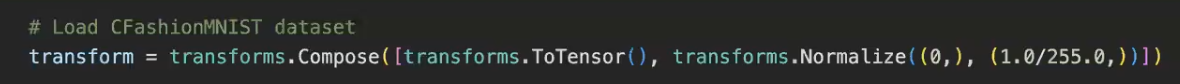

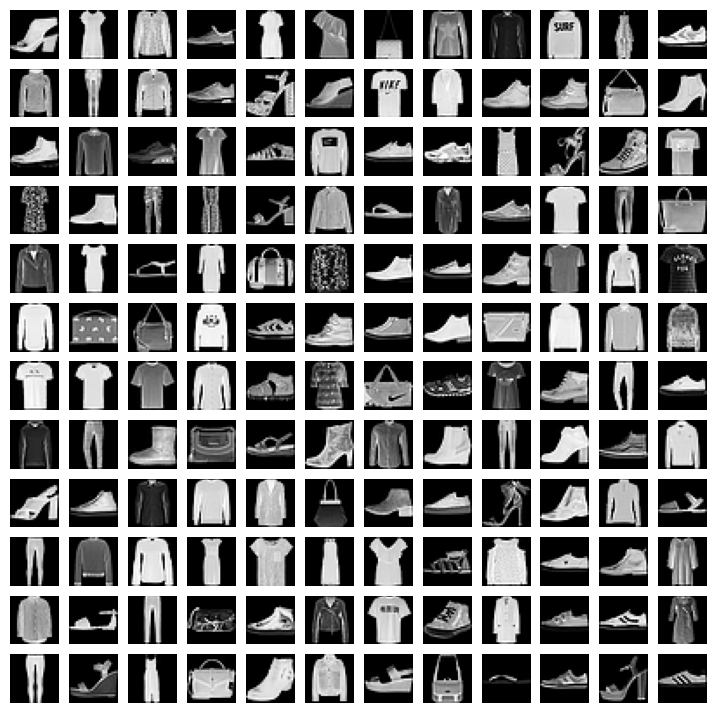

In [97]:
# image indices
from matplotlib import pyplot as plt


indices = np.random.randint(X_train.shape[0], size=144)

fig = plt.figure(figsize=(9, 9))
col = 12
row = 12

for i in range(1, col*row + 1):
    img = X_train[indices[i - 1]].reshape(28, 28)
    fig.add_subplot(row, col, i) # add small plot within the whole plot
    plt.axis('off')
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)

to_tensor() - auto convert Pil image value to [0, 1] tensor value range.
 
crossentropy loss function contain Softmax by default

In [98]:
softmax_regression_model = nn.Sequential(
    nn.Flatten(), # start flatten from 1D to 1D (start_dim=1, end_dim=1)
    nn.Linear(784, 256), # return z, not yhat

    nn.ReLU(), # return z, not yhat
    nn.Linear(256, 10) # return z, not yhat
)
softmax_regression_model.to(device)
print(softmax_regression_model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=10, bias=True)
)


In [99]:
width = 28
height = 28
images = torch.rand(32, 1, width, height).to(device) # Total Sample, C, H, W. Also convert to CUDA array format
image = images / (width*height) # normalize input data to [0, 1]
z = softmax_regression_model(images)
print(z.shape)

torch.Size([32, 10])


In [118]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(trainset, batch_size=512, shuffle=True)
test_dataloader = DataLoader(testset, batch_size=512, shuffle=True)

In [101]:
train_losses = []
train_accuracies = []
test_accuracies = []

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()

    for batch, (X_train, y_train) in enumerate(dataloader):
        X, y = X_train.to(device), y_train.to(device)

        #? Forward pass
        pred = model(X)
        loss = loss_fn(pred, y) # prediction output, target input
        train_losses.append(loss)

        # Determine class predictions and track accuracy
        _, predicted = torch.max(pred.data, 1) # return max value by C index (dimension index, if 2D then index 2, if 1D then index 1)
        correct = (predicted == y).sum() # {labels: correct_label_count}.item() #? tensor(54, device='cuda:0')
        # print('CR format:', correct)

        #? Back Propagation
        loss.backward() # calc Gradient base on defined Loss function
        optimizer.step() # update weight and bias parameters
        optimizer.zero_grad() # reset gradient calculation after each batch

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:7f} [{current:>5d} / {size:>5d}]")


In [102]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad(): # disable gradient calculation
        for X_test, y_test in dataloader:
            X, y = X_test.to(device), y_test.to(device)
            pred = model(X) #? tensor(0.4660, device='cuda:0')
            # print('PRED SHAPE:', pred.shape) # (64, 10) - batch of 64 images and 10 pred classes
            test_loss = loss_fn(pred, y)
            # print('LS:', test_loss)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [103]:
epochs = 10
optimizer = torch.optim.SGD(softmax_regression_model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------")
    train(train_dataloader, softmax_regression_model, loss_fn=loss_fn, optimizer=optimizer)
    test(test_dataloader, softmax_regression_model, loss_fn=loss_fn)
print("FINISH")

Epoch 1
-------------------------
loss: 2.346731 [   64 / 60000]
loss: 1.140009 [ 6464 / 60000]
loss: 0.900531 [12864 / 60000]
loss: 0.586431 [19264 / 60000]
loss: 0.673522 [25664 / 60000]
loss: 0.629715 [32064 / 60000]
loss: 0.511066 [38464 / 60000]
loss: 0.589981 [44864 / 60000]
loss: 0.669234 [51264 / 60000]
loss: 0.575906 [57664 / 60000]
Test Error: 
 Accuracy: 79.9%, Avg loss: 0.000420 

Epoch 2
-------------------------
loss: 0.551528 [   64 / 60000]
loss: 0.773178 [ 6464 / 60000]
loss: 0.629823 [12864 / 60000]
loss: 0.416580 [19264 / 60000]
loss: 0.704940 [25664 / 60000]
loss: 0.578481 [32064 / 60000]
loss: 0.568316 [38464 / 60000]
loss: 0.419017 [44864 / 60000]
loss: 0.550446 [51264 / 60000]
loss: 0.418792 [57664 / 60000]
Test Error: 
 Accuracy: 82.6%, Avg loss: 0.000602 

Epoch 3
-------------------------
loss: 0.446063 [   64 / 60000]
loss: 0.456516 [ 6464 / 60000]
loss: 0.392756 [12864 / 60000]
loss: 0.372923 [19264 / 60000]
loss: 0.400926 [25664 / 60000]
loss: 0.486637 [320

### Classification with MLP

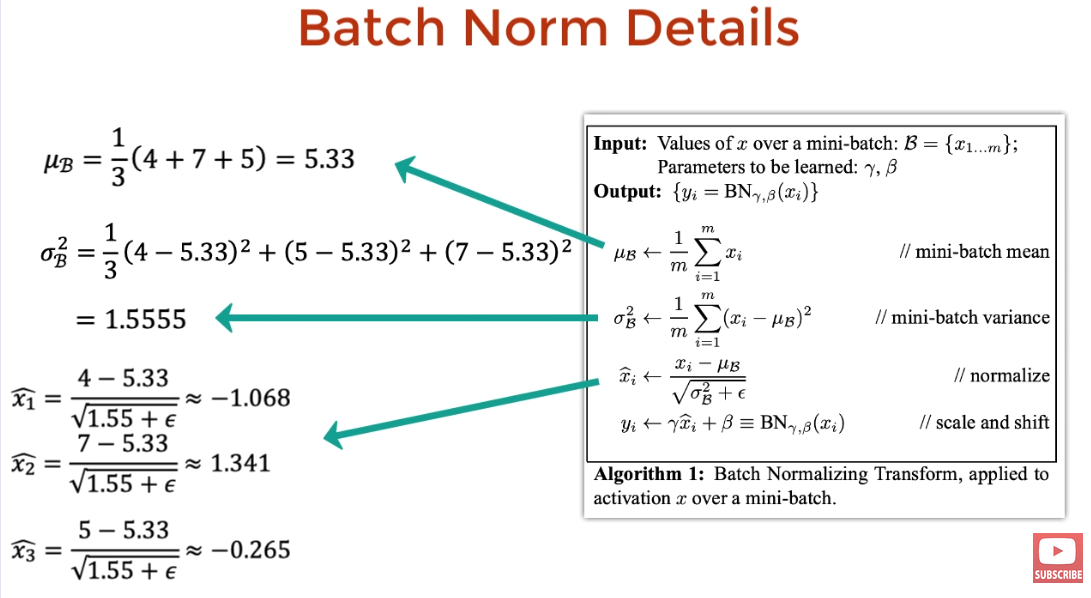

In [116]:
# without batch norm = 0.89
# with batch norm 0.906
mlp_model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),

    nn.Linear(256, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),

    nn.Linear(128, 10),
    nn.BatchNorm1d(10)
)

class MLP(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.flatten = nn.Flatten()
        self.layer_1 = nn.Sequential(
            nn.Linear(784, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
        )
        self.residual_layer = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 128), # add another layer to maintain 128 features before the final layer
            nn.BatchNorm1d(128)
        )

        # This layer (X) maps the input features to match the output features for addition
        self.skip_projection = nn.Linear(256, 128)
        self.output_layer = nn.Linear(128, 10)


    def forward(self, x):
        X = self.flatten(x)
        #? Activation func from 1st layer
        a1 = self.layer_1(X)

        #? Residual layer (h for hidden)
        h_res_out = self.residual_layer(a1)
        h_skip_proj = self.skip_projection(a1)

        h_combined = h_res_out + h_skip_proj

        h_final = nn.ReLU()(h_combined) # 128 features

        logits = self.output_layer(h_final)

        return logits

mlp_model = MLP().to(device)
mlp_model


MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer_1): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (residual_layer): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (skip_projection): Linear(in_features=256, out_features=128, bias=True)
  (output_layer): Linear(in_features=128, out_features=10, bias=True)
)

In [117]:
epochs = 5
optimizer = torch.optim.SGD(mlp_model.parameters(), lr=0.01, momentum=0.4)
loss_fn = nn.CrossEntropyLoss()

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------")
    train(train_dataloader, mlp_model, loss_fn=loss_fn, optimizer=optimizer)
    test(test_dataloader, mlp_model, loss_fn=loss_fn)
print("FINISH")

Epoch 1
-------------------------
loss: 2.460440 [   64 / 60000]
loss: 0.554443 [ 6464 / 60000]
loss: 0.433849 [12864 / 60000]
loss: 0.577419 [19264 / 60000]
loss: 0.547823 [25664 / 60000]
loss: 0.516573 [32064 / 60000]
loss: 0.558976 [38464 / 60000]
loss: 0.355262 [44864 / 60000]
loss: 0.363137 [51264 / 60000]
loss: 0.289243 [57664 / 60000]
Test Error: 
 Accuracy: 87.1%, Avg loss: 0.000364 

Epoch 2
-------------------------
loss: 0.368054 [   64 / 60000]
loss: 0.384829 [ 6464 / 60000]
loss: 0.375761 [12864 / 60000]
loss: 0.378721 [19264 / 60000]
loss: 0.177021 [25664 / 60000]
loss: 0.219773 [32064 / 60000]
loss: 0.235210 [38464 / 60000]
loss: 0.331898 [44864 / 60000]
loss: 0.363452 [51264 / 60000]
loss: 0.328820 [57664 / 60000]
Test Error: 
 Accuracy: 88.8%, Avg loss: 0.000462 

Epoch 3
-------------------------
loss: 0.327214 [   64 / 60000]
loss: 0.350855 [ 6464 / 60000]
loss: 0.226501 [12864 / 60000]
loss: 0.213291 [19264 / 60000]
loss: 0.208485 [25664 / 60000]
loss: 0.329200 [320